This website is built for predicting whether the patient is in high risk or not based on some current symptoms and medical history. It is used The model is trained by the dataset provided by the Mexican government (see link: https://datos.gob.mx/busca/dataset/informacion-referente-a-casos-covid-19-en-mexico)

In [274]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score
from sklearn.metrics import roc_auc_score, roc_curve,accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier
from collections import Counter
from mlxtend.plotting import plot_decision_regions

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

In [275]:
df = pd.read_csv("covid_data.csv")
df

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,2,13,2,1,9999-99-99,97,2,40,97,2,...,2,2,2,2,2,2,2,2,7,97
1048571,1,13,2,2,9999-99-99,2,2,51,97,2,...,2,2,1,2,2,2,2,2,7,2
1048572,2,13,2,1,9999-99-99,97,2,55,97,2,...,2,2,2,2,2,2,2,2,7,97
1048573,2,13,2,1,9999-99-99,97,2,28,97,2,...,2,2,2,2,2,2,2,2,7,97


The dataset was provided by the Mexican government (link). This dataset contains an enormous number of anonymized patient-related information including pre-conditions. The raw dataset consists of 21 unique features and 1,048,576 unique patients. In the Boolean features,**1 means "yes" and 2 means "no". values as 97 and 99 are missing data**.

**sex**: 1 for female and 2 for male. 

**classification**: covid test findings. Values 1-3 mean that the patient was diagnosed with covid in different
degrees. 4 or higher means that the patient is not a carrier of covid or that the test is inconclusive. 

**patient type**: type of care the patient received in the unit. 1 for returned home and 2 for hospitalization.

**pneumonia**: whether the patient already have air sacs inflammation or not. akciğer hava kesesi iltihabı 

**pregnancy**: whether the patient is pregnant or not.

**diabetes**: whether the patient has diabetes or not.

**copd**: Indicates whether the patient has Chronic obstructive pulmonary disease or not. (**Kronik akciğer hastalığı**)

**asthma**: whether the patient has asthma or not.

**inmsupr**: whether the patient is immunosuppressed or not. (**bağışıklığın çökmesi**)

**hypertension**: whether the patient has hypertension or not.

**cardiovascular**: whether the patient has heart or blood vessels related disease.

**renal chronic**: whether the patient has chronic renal disease or not.

**other disease**: whether the patient has other disease or not.

**obesity**: whether the patient is obese or not.

**tobacco**: whether the patient is a tobacco user.

**usmr**: Indicates whether the patient treated medical units of the first, second or third level.

**medical unit**: type of institution of the National Health System that provided the care.

**intubed**: whether the patient was connected to the ventilator. (suni solunum)

**icu**: Indicates whether the patient had been admitted to an Intensive Care Unit. (yoğun bakıma giriş)

**date died**: If the patient died indicate the date of death, and 9999-99-99 otherwise.

In [276]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   USMER                 1048575 non-null  int64 
 1   MEDICAL_UNIT          1048575 non-null  int64 
 2   SEX                   1048575 non-null  int64 
 3   PATIENT_TYPE          1048575 non-null  int64 
 4   DATE_DIED             1048575 non-null  object
 5   INTUBED               1048575 non-null  int64 
 6   PNEUMONIA             1048575 non-null  int64 
 7   AGE                   1048575 non-null  int64 
 8   PREGNANT              1048575 non-null  int64 
 9   DIABETES              1048575 non-null  int64 
 10  COPD                  1048575 non-null  int64 
 11  ASTHMA                1048575 non-null  int64 
 12  INMSUPR               1048575 non-null  int64 
 13  HIPERTENSION          1048575 non-null  int64 
 14  OTHER_DISEASE         1048575 non-null  int64 
 15

# DATA CLEANING & MANIPULATION

In [277]:
df.SEX = pd.get_dummies(df["SEX"],drop_first=True) # Erkek ise 1, kız ise 0

In [278]:
# 1 for returned home and 2 for hospitalization.
df.PATIENT_TYPE.value_counts()

1    848544
2    200031
Name: PATIENT_TYPE, dtype: int64

In [279]:
# ask hospitazation? if yes 1 otherwise 0
df.PATIENT_TYPE = pd.get_dummies(df.PATIENT_TYPE)[2]

In [280]:
df.rename(columns = {'PATIENT_TYPE':'HOSP'},inplace=True)

Construction of the target column 

In [281]:
df.DATE_DIED.value_counts()

9999-99-99    971633
06/07/2020      1000
07/07/2020       996
13/07/2020       990
16/06/2020       979
               ...  
24/11/2020         1
17/12/2020         1
08/12/2020         1
16/03/2021         1
22/04/2021         1
Name: DATE_DIED, Length: 401, dtype: int64

In [282]:
df["DIED"] = df.DATE_DIED.apply(lambda x: 0 if x == "9999-99-99" else 1 )
# 1 for dead, 0 for alive
df[["DIED","DATE_DIED"]] 

,DIED,DATE_DIED
0,1,03/05/2020
1,1,03/06/2020
2,1,09/06/2020
3,1,12/06/2020
4,1,21/06/2020
...,...,...
1048570,0,9999-99-99
1048571,0,9999-99-99
1048572,0,9999-99-99
1048573,0,9999-99-99


There are lots of missing values in the column INTUBE. So we drop it!

In [283]:
df.drop(columns=["INTUBED"],inplace=True)

We set nan values for 99 in the column PNEUMONIA

In [284]:
df.PNEUMONIA.value_counts()

2     892534
1     140038
99     16003
Name: PNEUMONIA, dtype: int64

In [285]:
df.PNEUMONIA = df.PNEUMONIA.apply(lambda x : np.NaN if x==99 else x)
df.drop(df[df.PNEUMONIA.isna()==True].index, inplace=True)

In [286]:
df.PNEUMONIA.astype(int)
# 1 yes, 2 no 

0          1
1          1
2          2
3          2
4          2
          ..
1048570    2
1048571    2
1048572    2
1048573    2
1048574    2
Name: PNEUMONIA, Length: 1032572, dtype: int32

In [287]:
df.PNEUMONIA = pd.get_dummies(df.PNEUMONIA)[1.0]

Pregnant column:

In [288]:
df.PREGNANT.value_counts()
# 1 yes, 2 no

97    516154
2     505159
1       7870
98      3389
Name: PREGNANT, dtype: int64

Kadınlarda hamilelik bilgisi olmayan satırları (3754 tane) silelim:

In [289]:
# 3754  tane satır eksilecek
df.drop(df[((df.PREGNANT == 97) | (df.PREGNANT == 98)) & (df.SEX == 0)].index,inplace=True)

In [290]:
df.PREGNANT.value_counts()

97    516154
2     505159
1       7870
Name: PREGNANT, dtype: int64

In [291]:
df[df.SEX == 1]["PREGNANT"].value_counts()

97    516154
Name: PREGNANT, dtype: int64

In [292]:
df.PREGNANT = df.PREGNANT.apply(lambda x: 2 if x==97 else x)
df.PREGNANT = df.PREGNANT.map({1:"yes",2:"no"})
df.PREGNANT = pd.get_dummies(df.PREGNANT, drop_first=True)

Assign Nan to values 97 and 98.

In [293]:
df.replace({98:np.NaN,97:np.NaN},inplace=True)

DIABETES:

In [294]:
df.drop(df[df.DIABETES == 98].index,inplace=True)

In [295]:
df.DIABETES = pd.get_dummies(df.DIABETES)[1]

In [296]:
df.drop(df[df.COPD.isna()==True]["COPD"].index,inplace=True)
df.COPD = pd.get_dummies(df.COPD)[1.0]

In [297]:
df.drop(df[df.ASTHMA.isna() == True].index,inplace=True)
df.ASTHMA = pd.get_dummies(df.ASTHMA)[1.0]

In [298]:
df.drop(df[df.INMSUPR.isna() == True].index,inplace=True)
df.INMSUPR = pd.get_dummies(df.INMSUPR)[1.0]

In [299]:
df.drop(df[df.HIPERTENSION.isna() == True].index,inplace=True)
df.HIPERTENSION = pd.get_dummies(df.HIPERTENSION)[1.0]

In [300]:
df.drop(df[df.OTHER_DISEASE.isna() == True].index,inplace=True)
df.OTHER_DISEASE = pd.get_dummies(df.OTHER_DISEASE)[1.0]

In [301]:
df.drop(df[df.CARDIOVASCULAR.isna() == True].index,inplace=True)
df.CARDIOVASCULAR = pd.get_dummies(df.CARDIOVASCULAR)[1.0]

In [302]:
df.drop(df[df.OBESITY.isna() == True].index,inplace=True)
df.OBESITY = pd.get_dummies(df.OBESITY)[1.0]

In [303]:
df.drop(df[df.RENAL_CHRONIC.isna() == True].index,inplace=True)
df.RENAL_CHRONIC = pd.get_dummies(df.RENAL_CHRONIC)[1.0]

CLASIFFICATION_FINAL:

In [304]:
df.CLASIFFICATION_FINAL.value_counts()

7    489078
3    377667
6    117445
5     25277
1      8430
4      3093
2      1801
Name: CLASIFFICATION_FINAL, dtype: int64

In [305]:
df.CLASIFFICATION_FINAL.replace([4,5,6,7,1,2,3],[4,4,4,4,1,2,3],inplace=True )

There are huge missing values in ICU (Yoğun bakım). That is why we drop the column!

In [306]:
df.drop(columns=["ICU"],inplace=True)

In [307]:
# Not that here 98 is real age 
df.AGE.replace(np.nan,98,inplace=True)

<AxesSubplot:xlabel='AGE', ylabel='Count'>

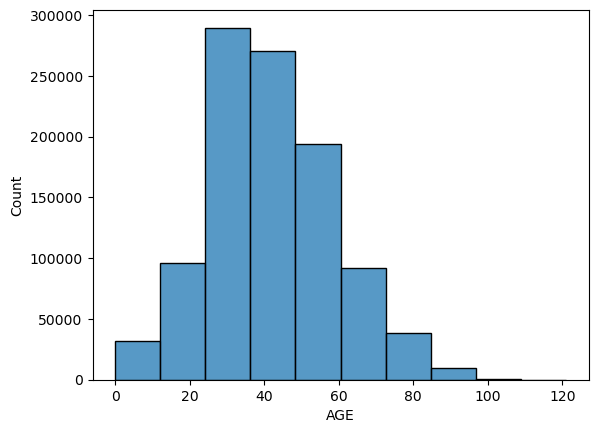

In [308]:
sns.histplot(df.AGE,bins=10)

In [309]:
def func(x):
    if 20>x:
        return "0-20"
    elif 40>x:
        return "20-40"
    elif 60>x:
        return "40-60"
    else:
        return ">60"    

df.AGE=df.AGE.map(func)
df = pd.get_dummies(df,columns=["AGE"],drop_first=True)

In [310]:
df.drop(df[df.TOBACCO.isna() == True].index,inplace=True)

In [311]:
df["TOBACCO"] = pd.get_dummies(df["TOBACCO"])[1.0]

Son olarak eksilen satırlardan dolayı indeksi resetleyelim:

In [312]:
df.isna().sum()

USMER                   0
MEDICAL_UNIT            0
SEX                     0
HOSP                    0
DATE_DIED               0
PNEUMONIA               0
PREGNANT                0
DIABETES                0
COPD                    0
ASTHMA                  0
INMSUPR                 0
HIPERTENSION            0
OTHER_DISEASE           0
CARDIOVASCULAR          0
OBESITY                 0
RENAL_CHRONIC           0
TOBACCO                 0
CLASIFFICATION_FINAL    0
DIED                    0
AGE_20-40               0
AGE_40-60               0
AGE_>60                 0
dtype: int64

In [313]:
df.reset_index(inplace = True, drop = True)

In [314]:
# sns.heatmap(df.isna(),yticklabels=False,cbar=False)

In [315]:
df.drop(columns="DATE_DIED",inplace=True)

In [316]:
# Shuffle rows of dataframe
df=df.sample(frac = 1).reset_index(drop=True)
# split target column
X = df.drop(columns="DIED")
y = df.DIED

In [317]:
print(X.shape)
print(y.shape)

(1022422, 20)
(1022422,)


Veri çok dengesiz

In [318]:
y.value_counts()

0    947708
1     74714
Name: DIED, dtype: int64

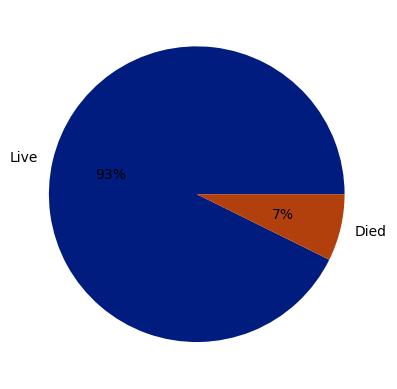

In [319]:
keys = ['Live', 'Died']
# define Seaborn color palette to use
palette_color = sns.color_palette('dark')
  
# plotting data on chart
plt.pie(y.value_counts(), labels=keys, colors=palette_color, autopct='%.0f%%');

Veri bu haliyle dengesiz. Herhangi bir model herkes yaşayacak dese yüzde 93 başarı(accuracy) verecek.

In [320]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.20, random_state=42)

**Logistic Regression**

In [321]:
log1 = LogisticRegression(solver='liblinear')
log1.fit(X_train,Y_train)
print("Training Accuracy:", round(log1.score(X_train, Y_train), 3))
print("Testing Accuracy:", round(log1.score(X_test, Y_test), 3))

Training Accuracy: 0.937
Testing Accuracy: 0.937


In [322]:
pred = log1.predict(X_test)
print(classification_report(Y_test,pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97    189549
           1       0.59      0.44      0.50     14936

    accuracy                           0.94    204485
   macro avg       0.78      0.71      0.73    204485
weighted avg       0.93      0.94      0.93    204485



Gerçekte ölenlerin yalnız yüzde 43 ünü tahmin edebiliyoruz.

# Selecting Important Features

<AxesSubplot:ylabel='CLASIFFICATION_FINAL'>

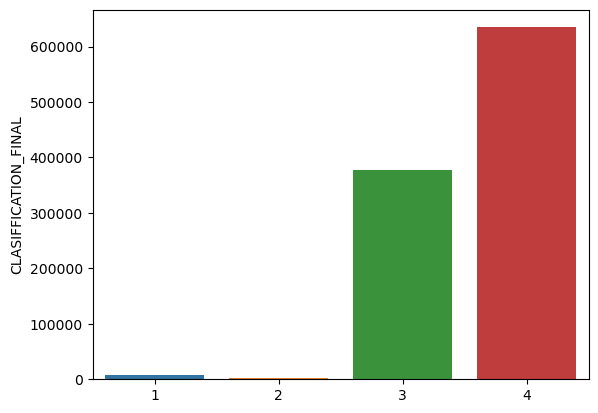

In [323]:
# tüm datada covidtest sonuç dağılımı
sns.barplot(y=df["CLASIFFICATION_FINAL"].value_counts(),x=df["CLASIFFICATION_FINAL"].value_counts().index)

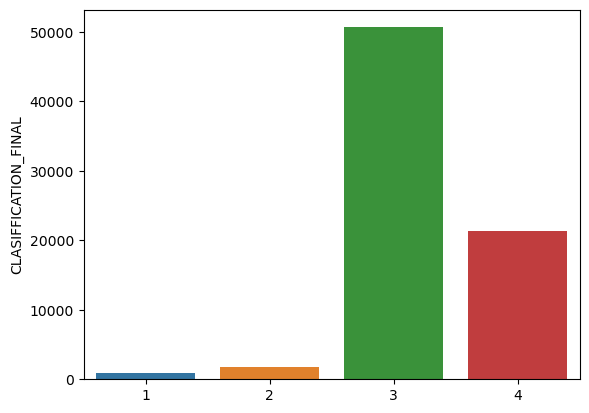

In [324]:
# ölenlerin covid testi sonuçları
died_covid_test = df[df.DIED == 1]["CLASIFFICATION_FINAL"]
sns.barplot(y=died_covid_test.value_counts(),x=died_covid_test.value_counts().index);

In [325]:
covid_pos = df[4>df["CLASIFFICATION_FINAL"]]

In [326]:
covid_pos["DIED"].value_counts()

0    334393
1     53355
Name: DIED, dtype: int64

<AxesSubplot:ylabel='DIED'>

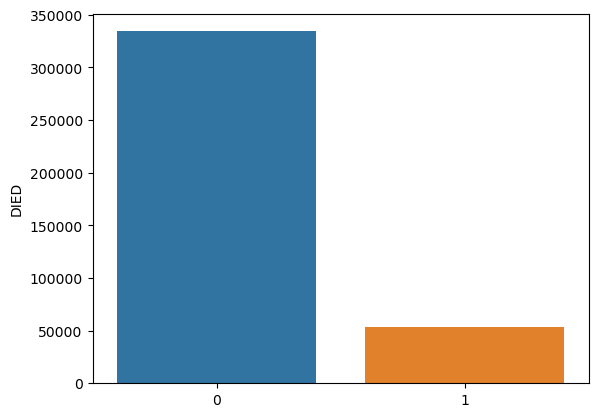

In [327]:
sns.barplot(y=covid_pos["DIED"].value_counts(),x=covid_pos["DIED"].value_counts().index)

# Undersampling

In [328]:
y.value_counts()

0    947708
1     74714
Name: DIED, dtype: int64

In [329]:
from imblearn.under_sampling import RandomUnderSampler
X, y = RandomUnderSampler().fit_resample(X,y)

In [330]:
y.value_counts()

0    74714
1    74714
Name: DIED, dtype: int64

In [331]:
print(X.shape)
print(y.shape)

(149428, 20)
(149428,)


Artık elimizde 149428 tane hastanın verisi var.

In [332]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.20, random_state=42)
x_train, x_val, y_train, y_val= train_test_split(X_train, Y_train, test_size=0.20, random_state=42)

In [333]:
Y_test.value_counts()

1    14962
0    14924
Name: DIED, dtype: int64

In [334]:
y_val.value_counts()

1    11963
0    11946
Name: DIED, dtype: int64

bağımlı değişken gayet dengeli

In [335]:
print("x_train shape",x_train.shape)
print("y_train shape",y_train.shape)
print("x_val shape",x_val.shape)
print("y_val shape:",y_val.shape)

x_train shape (95633, 20)
y_train shape (95633,)
x_val shape (23909, 20)
y_val shape: (23909,)


x_train, y_train ile modeller eğitip, validasyon seti ile modelleri kıyaslayacağız

# 1. Logistic Regression

In [336]:
log = LogisticRegression(solver='liblinear')
log.fit(x_train,y_train)
log_train_acc_score = round(log.score(x_train, y_train), 3)
log_val_acc_score = round(log.score(x_val, y_val), 3)
print("Training Accuracy:", log_train_acc_score)
print("Validation Accuracy:", log_val_acc_score )
pred_log = log.predict(x_val) 
precision_log = round(precision_score(y_val,pred_log),3)
print("Precision for death:",precision_log)
recall_log = round(recall_score(y_val,pred_log),3)
print("Recall for death:",recall_log)           

Training Accuracy: 0.904
Validation Accuracy: 0.909
Precision for death: 0.898
Recall for death: 0.924


In [337]:
print(classification_report(y_val,pred_log))

              precision    recall  f1-score   support

           0       0.92      0.89      0.91     11946
           1       0.90      0.92      0.91     11963

    accuracy                           0.91     23909
   macro avg       0.91      0.91      0.91     23909
weighted avg       0.91      0.91      0.91     23909



In [338]:
def make_confusion_matrix(model, threshold=0.5): # Ön tanımlı threshold değeri
    pred = (model.predict_proba(x_val) >= threshold)[:, 1]
    mat = confusion_matrix(y_val, pred)
    sns.heatmap(mat, cmap=plt.cm.Blues, annot=True, square=True,fmt=".0f", 
                xticklabels=["LIVE","DIED"],yticklabels=["LIVE","DIED"])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    print("Precision for DEATH:",round(precision_score(y_val,pred),3))
    print("Recall for DEATH:",round(recall_score(y_val,pred),3))
    print("Accuracy:",round((mat[0,0] +mat[1,1])/(mat[0,0]+mat[1,1]+mat[0,1]+mat[1,0]),4));

In [339]:
# Threshold değerini değiştirdiğimizde sonucun da interaktif bir şekilde değişmesi için bir widget
from ipywidgets import interactive, FloatSlider
interactive(lambda threshold: make_confusion_matrix(log, threshold), threshold=(0.0,1.0,0.05))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.05), Output()), _dom_cla…

Precision for DEATH: 0.903
Recall for DEATH: 0.897
Accuracy: 0.9002


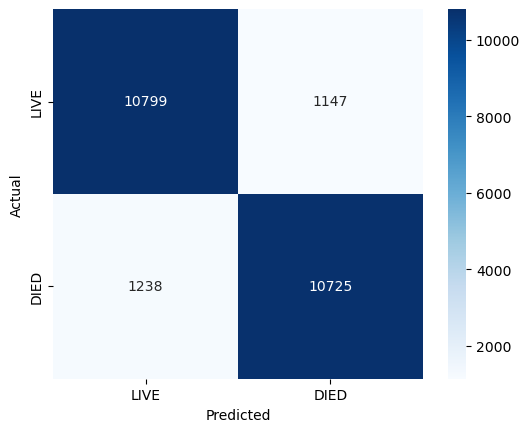

In [340]:
make_confusion_matrix(log,threshold=0.6)

**AŞAĞIDA HATA VAR!!!!**

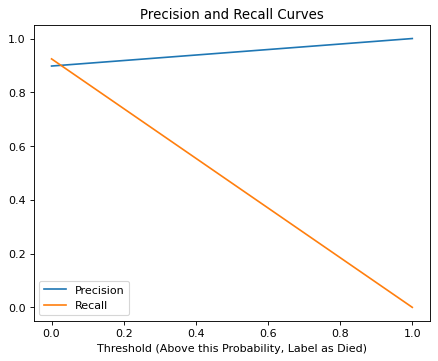

In [341]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val,pred_log)

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:], label='Precision')
plt.plot(threshold_curve, recall_curve[1:], label='Recall')
plt.legend()
plt.xlabel('Threshold (Above this Probability, Label as Died)');
plt.title('Precision and Recall Curves');

AUC Score= 0.956


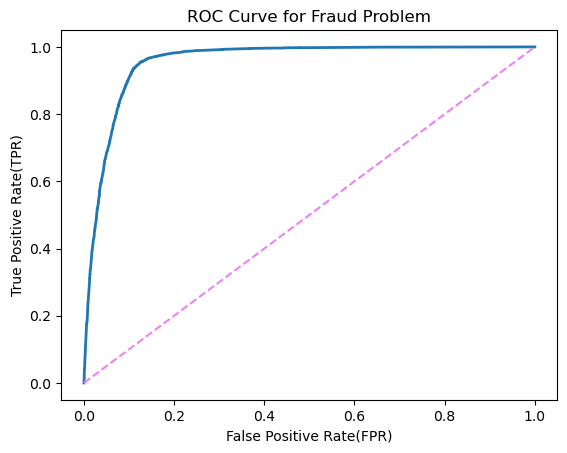

In [342]:
fpr, tpr, thresholds = roc_curve(y_val, log.predict_proba(x_val)[:,1])

plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False Positive Rate(FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.title('ROC Curve for Fraud Problem');
print("AUC Score=", round(roc_auc_score(y_val, log.predict_proba(x_val)[:,1]),3))

In [343]:
from sklearn.metrics import log_loss

print("Log-Loss: {:2.3f}".format(log_loss(y_val, log.predict_proba(x_val))))

Log-Loss: 0.252


### Feature Importance

In [344]:
pd.Series(log.coef_[0])

0    -0.068848
1    -0.113310
2     0.521236
3     2.806899
4     1.586678
5    -0.137075
6     0.387004
7     0.239953
8    -0.164130
9     0.448217
10    0.158365
11    0.307845
12   -0.036938
13    0.262249
14    0.559844
15   -0.198441
16   -0.766635
17    0.164183
18    1.225259
19    2.307527
dtype: float64

Feature: 0, Coef: -0.0688
Feature: 1, Coef: -0.1133
Feature: 2, Coef: 0.5212
Feature: 3, Coef: 2.8069
Feature: 4, Coef: 1.5867
Feature: 5, Coef: -0.1371
Feature: 6, Coef: 0.3870
Feature: 7, Coef: 0.2400
Feature: 8, Coef: -0.1641
Feature: 9, Coef: 0.4482
Feature: 10, Coef: 0.1584
Feature: 11, Coef: 0.3078
Feature: 12, Coef: -0.0369
Feature: 13, Coef: 0.2622
Feature: 14, Coef: 0.5598
Feature: 15, Coef: -0.1984
Feature: 16, Coef: -0.7666
Feature: 17, Coef: 0.1642
Feature: 18, Coef: 1.2253
Feature: 19, Coef: 2.3075


<BarContainer object of 20 artists>

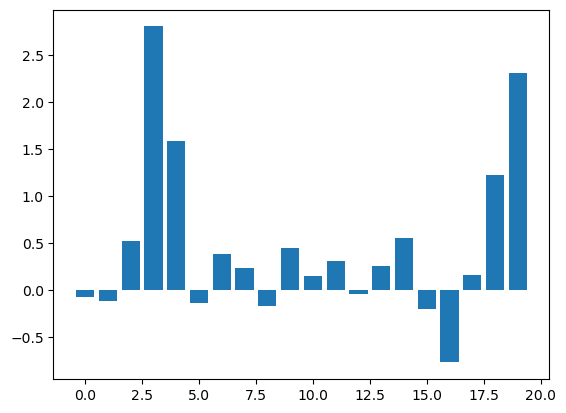

In [345]:
# get importance
importance = log.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Coef: %.4f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)

**Statsmodel**

In [346]:
pd.Series(X.columns)

0                    USMER
1             MEDICAL_UNIT
2                      SEX
3                     HOSP
4                PNEUMONIA
5                 PREGNANT
6                 DIABETES
7                     COPD
8                   ASTHMA
9                  INMSUPR
10            HIPERTENSION
11           OTHER_DISEASE
12          CARDIOVASCULAR
13                 OBESITY
14           RENAL_CHRONIC
15                 TOBACCO
16    CLASIFFICATION_FINAL
17               AGE_20-40
18               AGE_40-60
19                 AGE_>60
dtype: object

In [347]:
import statsmodels.api as sm
logit_model=sm.Logit(y_train,x_train)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.261924
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                   DIED   No. Observations:                95633
Model:                          Logit   Df Residuals:                    95613
Method:                           MLE   Df Model:                           19
Date:                Mon, 02 Jan 2023   Pseudo R-squ.:                  0.6221
Time:                        15:49:39   Log-Likelihood:                -25049.
converged:                       True   LL-Null:                       -66288.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
USMER                   -0.0941      0.023     -4.150      0.000      -0.139      -0.050

We may drop the columns : COPD, CARDIOVASCULAR by considering p values        

In [348]:
X=X.drop(["COPD","CARDIOVASCULAR","ASTHMA","PREGNANT","AGE_20-40"], axis=1)

In [349]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.20, random_state=42)
x_train, x_val, y_train, y_val= train_test_split(X_train, Y_train, test_size=0.20, random_state=42)

In [350]:
import statsmodels.api as sm
logit_model=sm.Logit(y_train,x_train)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.262021
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                   DIED   No. Observations:                95633
Model:                          Logit   Df Residuals:                    95618
Method:                           MLE   Df Model:                           14
Date:                Mon, 02 Jan 2023   Pseudo R-squ.:                  0.6220
Time:                        15:50:26   Log-Likelihood:                -25058.
converged:                       True   LL-Null:                       -66288.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
USMER                   -0.0903      0.022     -4.119      0.000      -0.133      -0.047

In [351]:
log = LogisticRegression(solver='liblinear')
log.fit(x_train,y_train)
log_train_acc_score = round(log.score(x_train, y_train), 3)
log_val_acc_score = round(log.score(x_val, y_val), 3)
print("Training Accuracy:", log_train_acc_score)
print("Validation Accuracy:", log_val_acc_score )
pred_log = log.predict(x_val) 
precision_log = round(precision_score(y_val,pred_log),3)
print("Precision for death:",precision_log)
recall_log = round(recall_score(y_val,pred_log),3)
print("Recall for death:",recall_log)           

Training Accuracy: 0.905
Validation Accuracy: 0.91
Precision for death: 0.898
Recall for death: 0.925


# Support Vector Classifier (SVC)

modeli kaydedelim:

In [354]:
from joblib import dump, load
svc = load('svc_model.pkl')

In [356]:
pred_svc = load('pred_svc.pkl')

In [359]:
svc_train_acc_score = load('svc_train_acc_score.pkl')
svc_val_acc_score = load('svc_val_acc_score.pkl')
svc_precision = load('svc_precision.pkl')
svc_recall = load('svc_recall.pkl')

In [360]:
print(classification_report(y_val,pred_svc))

              precision    recall  f1-score   support

           0       0.92      0.87      0.90     11946
           1       0.88      0.93      0.90     11963

    accuracy                           0.90     23909
   macro avg       0.90      0.90      0.90     23909
weighted avg       0.90      0.90      0.90     23909



# XGBClassifier

In [361]:
xgb = XGBClassifier().fit(x_train, y_train)

In [362]:
pred_xgb = xgb.predict(x_val)

In [363]:
xgb_train_acc_score = round(xgb.score(x_train, y_train), 3)
xgb_val_acc_score = round(xgb.score(x_val, y_val), 3)
print(f"Accuracy_train:", xgb_train_acc_score)
print(f'Accuracy_val: {xgb_val_acc_score}')
xgb_precision = round(precision_score(y_val,pred_xgb),3)
print(f'Precision: {xgb_precision}')
xgb_recall = round(recall_score(y_val,pred_xgb),3)
print(f"Recall: {xgb_recall}")

Accuracy_train: 0.917
Accuracy_val: 0.919
Precision: 0.89
Recall: 0.956


precision for death: 0.8897797151085857
recall for death: 0.9555295494441194


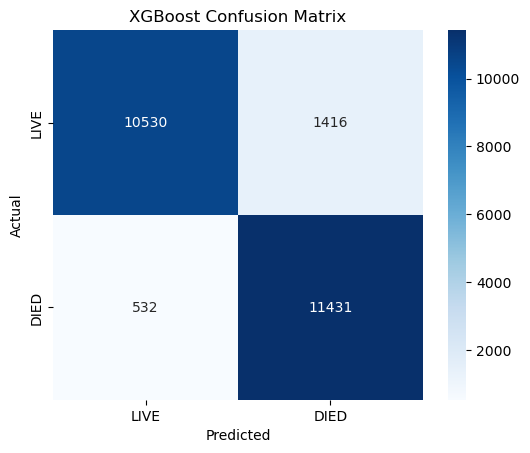

In [364]:
xgb_confusion = confusion_matrix(y_val, pred_xgb)

plt.title('XGBoost Confusion Matrix')
sns.heatmap(xgb_confusion, cmap=plt.cm.Blues, annot=True, square=True,fmt=".0f",
            xticklabels=["LIVE","DIED"],yticklabels=["LIVE","DIED"])
plt.xlabel('Predicted')
plt.ylabel('Actual');
print("precision for death:",precision_score(y_val,pred_xgb))
print("recall for death:",recall_score(y_val,pred_xgb))

In [365]:
from sklearn.metrics import classification_report 
print(classification_report(y_val,pred_xgb))

              precision    recall  f1-score   support

           0       0.95      0.88      0.92     11946
           1       0.89      0.96      0.92     11963

    accuracy                           0.92     23909
   macro avg       0.92      0.92      0.92     23909
weighted avg       0.92      0.92      0.92     23909



# Random Forest

In [366]:
random_forest = RandomForestClassifier()
random_forest.fit(x_train, y_train)

pred_forest = random_forest.predict(x_val)

acc_random_forest_train = round(random_forest.score(x_train, y_train) , 3)
acc_random_forest_val = round(random_forest.score(x_val, y_val) , 3)

In [367]:
print(acc_random_forest_train)
print(acc_random_forest_val)
precision_forest = round(precision_score(y_val,pred_forest),3)
print("precision:",precision_forest)
recall_forest = round(recall_score(y_val,pred_forest),3)
print("recall:", recall_forest)

0.926
0.913
precision: 0.887
recall: 0.945


In [368]:
print(classification_report(y_val,pred_forest))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91     11946
           1       0.89      0.95      0.92     11963

    accuracy                           0.91     23909
   macro avg       0.91      0.91      0.91     23909
weighted avg       0.91      0.91      0.91     23909



# GaussianNB

In [369]:
gaussian = GaussianNB()
gaussian.fit(x_train, y_train)  

pred_gaussian = gaussian.predict(x_val)  

acc_gaussian_train = round(gaussian.score(x_train, y_train) , 3)
acc_gaussian_val = round(gaussian.score(x_val, y_val) , 3)

In [370]:
print(acc_gaussian_train)
print(acc_gaussian_val)
precision_gaussian = round(precision_score(y_val,pred_gaussian),3)
print("precision:",precision_gaussian)
recall_gaussian = round(recall_score(y_val,pred_gaussian),3)
print("recall:", recall_gaussian)

0.88
0.885
precision: 0.873
recall: 0.9


In [371]:
print(classification_report(y_val,pred_gaussian))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88     11946
           1       0.87      0.90      0.89     11963

    accuracy                           0.88     23909
   macro avg       0.89      0.88      0.88     23909
weighted avg       0.89      0.88      0.88     23909



# Perceptron

In [372]:
perceptron = Perceptron()
perceptron.fit(x_train, y_train)

pred_perceptron = perceptron.predict(x_val)

acc_perceptron_train = round(perceptron.score(x_train, y_train) , 3)
acc_perceptron_val = round(perceptron.score(x_val, y_val) , 3)

In [373]:
print(acc_perceptron_train)
print(acc_perceptron_val)
precision_perceptron = round(precision_score(y_val,pred_perceptron),3)
print("precision:",precision_perceptron)
recall_perceptron = round(recall_score(y_val,pred_perceptron),3)
print("recall:", recall_perceptron)

0.736
0.74
precision: 0.926
recall: 0.522


In [374]:
print(classification_report(y_val,pred_perceptron))

              precision    recall  f1-score   support

           0       0.67      0.96      0.79     11946
           1       0.93      0.52      0.67     11963

    accuracy                           0.74     23909
   macro avg       0.80      0.74      0.73     23909
weighted avg       0.80      0.74      0.73     23909



# Decision Tree

In [375]:
decision_tree = DecisionTreeClassifier() 
decision_tree.fit(x_train, y_train) 

pred_tree = decision_tree.predict(x_val) 

acc_decision_tree_train = round(decision_tree.score(x_train, y_train) , 3)
acc_decision_tree_val = round(decision_tree.score(x_val, y_val) , 3)

In [376]:
print(acc_decision_tree_train)
print(acc_decision_tree_val)
precision_tree = round(precision_score(y_val,pred_tree),3)
print("precision:",precision_tree)
recall_tree = round(recall_score(y_val,pred_tree),3)
print("recall:", recall_tree)

0.926
0.906
precision: 0.889
recall: 0.929


In [377]:
print(classification_report(y_val,pred_tree))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90     11946
           1       0.89      0.93      0.91     11963

    accuracy                           0.91     23909
   macro avg       0.91      0.91      0.91     23909
weighted avg       0.91      0.91      0.91     23909



# KNN (hata verdi)

# TABLE OF VALIDATION SCORES

In [378]:
print(x_train.shape)
print(x_val.shape)

(95633, 15)
(23909, 15)


In [379]:
x_train.columns

Index(['USMER', 'MEDICAL_UNIT', 'SEX', 'HOSP', 'PNEUMONIA', 'DIABETES',
       'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'OBESITY', 'RENAL_CHRONIC',
       'TOBACCO', 'CLASIFFICATION_FINAL', 'AGE_40-60', 'AGE_>60'],
      dtype='object')

**95.633** tane hastanın 18 tane özelliklerine bakarak birtakım modeller eğittik. **23.909** tane hasta verisi (validation set) ile başarı skorlarını listeledik.

In [380]:
results = pd.DataFrame({
    'MODEL NAME': ['Support Vector Machines','Logistic Regression',"XGBoost","RandomForest",
              "GaussianNB","Perceptron"],
    "Train_acc_score": [svc_train_acc_score,log_train_acc_score, xgb_train_acc_score,
                        acc_random_forest_train,acc_gaussian_train,acc_perceptron_train],
    "Validation_acc_score": [svc_val_acc_score, log_val_acc_score, xgb_val_acc_score,
                             acc_random_forest_val,acc_gaussian_val,acc_perceptron_val],
    "Precision_death": [svc_precision,precision_log,xgb_precision, precision_forest,
                       precision_gaussian,precision_perceptron],
    "Recall_death": [svc_recall,recall_log,xgb_recall,recall_forest,recall_gaussian,recall_perceptron]
}

)

result_df = results.sort_values(by='Validation_acc_score', ascending=False)
result_df = result_df.set_index('MODEL NAME')
result_df.applymap(lambda x: round(x,2))

,Train_acc_score,Validation_acc_score,Precision_death,Recall_death
MODEL NAME,,,,
XGBoost,0.92,0.92,0.89,0.96
RandomForest,0.93,0.91,0.89,0.94
Logistic Regression,0.91,0.91,0.90,0.93
Support Vector Machines,0.90,0.90,0.88,0.93
GaussianNB,0.88,0.89,0.87,0.90
Perceptron,0.74,0.74,0.93,0.52


En iyi model olarak XGBoost görülüyor. Şimdi nihai olarak test seti ile yeniden skorlarına bakalım. 

In [381]:
model_xgb = xgb.fit(X_train,Y_train)
dump(model_xgb,"last_xgb")

['last_xgb']

In [382]:
pred_test = xgb.predict(X_test)

In [383]:
print(classification_report(Y_test,pred_test))

              precision    recall  f1-score   support

           0       0.95      0.87      0.91     14924
           1       0.88      0.95      0.92     14962

    accuracy                           0.91     29886
   macro avg       0.92      0.91      0.91     29886
weighted avg       0.92      0.91      0.91     29886



Yukardaki rapor validasyon seti ile aynı çıktı.

precision for death: 0.88
recall for death: 0.95


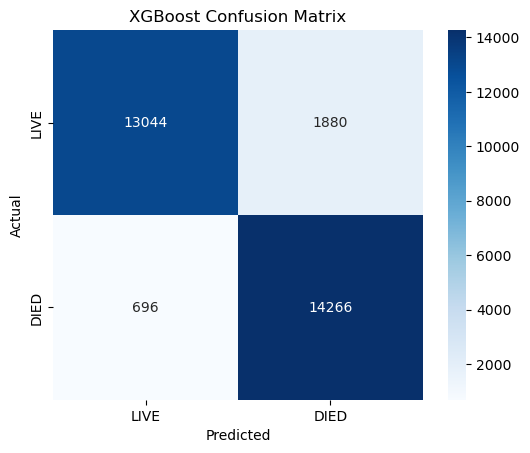

In [384]:
xgb_confusion = confusion_matrix(Y_test, pred_test)

plt.title('XGBoost Confusion Matrix')
sns.heatmap(xgb_confusion, cmap=plt.cm.Blues, annot=True, square=True,fmt=".0f",
            xticklabels=["LIVE","DIED"],yticklabels=["LIVE","DIED"])
plt.xlabel('Predicted')
plt.ylabel('Actual');
print("precision for death:",round(precision_score(Y_test,pred_test),2))
print("recall for death:",round(recall_score(Y_test,pred_test),2))

In [385]:
print("recall_lived:", round(13084/(13084+1840),2) )

recall_lived: 0.88


**cross validation**

Bir de cross validation ile teyit edelim: Scores: [0.91273506 0.91347119 0.91567958 0.91534498 0.91748645 0.91313659
 0.91306966 0.91601419 0.91252844 0.91620934]
Mean: 0.9145675482686617
Standard Deviation: 0.001678050071065035

**Best threshold = 0.7**

In [386]:
from ipywidgets import interactive, FloatSlider
interactive(lambda threshold: make_confusion_matrix(model_xgb, threshold), threshold=(0.0,1.0,0.05))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.05), Output()), _dom_cla…

**XGBoost success over the TEST set** 

In [387]:
len(X_test)

29886

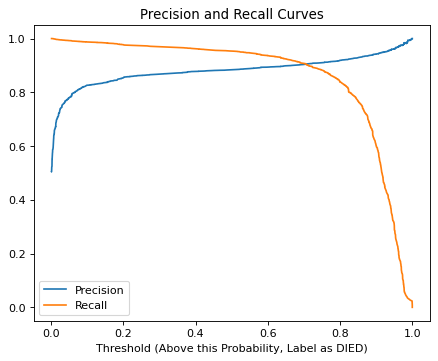

In [388]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(Y_test, model_xgb.predict_proba(X_test)[:,1])

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:], label='Precision')
plt.plot(threshold_curve, recall_curve[1:], label='Recall')

plt.legend()
plt.xlabel('Threshold (Above this Probability, Label as DIED)');
plt.title('Precision and Recall Curves');

Best Threshold: 0.72
Precision: 0.9070,   Recall: 0.8966 for DEAD
Precision for DEATH: 0.907
Recall for DEATH: 0.897
Accuracy: 0.9022


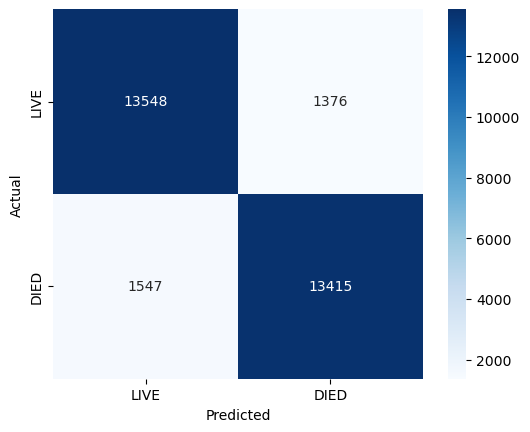

In [389]:
best_threshold = 0.72
pred_th = (model_xgb.predict_proba(X_test)[:,1] > best_threshold)
print('Best Threshold:', best_threshold)
print('Precision: {:6.4f},   Recall: {:6.4f} for DEAD'.format(precision_score(Y_test, pred_th), 
                                                     recall_score(Y_test, pred_th)))


mat = confusion_matrix(Y_test, pred_th)
sns.heatmap(mat, cmap=plt.cm.Blues, annot=True, square=True,fmt=".0f", 
                xticklabels=["LIVE","DIED"],yticklabels=["LIVE","DIED"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
print("Precision for DEATH:",round(precision_score(Y_test,pred_th),3))
print("Recall for DEATH:",round(recall_score(Y_test,pred_th),3))
print("Accuracy:",round((mat[0,0] +mat[1,1])/(mat[0,0]+mat[1,1]+mat[0,1]+mat[1,0]),4));

# MY TABLE

In [390]:
# target sütunun değişkenler sütunu ile birleştirelim
data = pd.concat([X_test,Y_test],axis=1)

In [391]:
data

,USMER,MEDICAL_UNIT,SEX,HOSP,PNEUMONIA,DIABETES,INMSUPR,HIPERTENSION,OTHER_DISEASE,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,AGE_40-60,AGE_>60,DIED
78020,2,4,1,1,0,1,0,0,0,0,0,0,3,0,1,1
57680,1,12,0,1,1,0,0,0,0,1,0,0,3,0,0,0
31925,1,4,1,1,0,0,0,0,0,0,0,0,4,0,0,0
83968,1,6,1,1,0,1,0,1,0,1,1,0,4,0,1,1
55623,1,12,1,1,0,0,1,0,0,0,0,0,4,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29710,2,9,1,1,0,0,0,0,0,0,0,0,4,0,1,0
89840,2,10,0,0,0,0,0,0,0,0,0,0,4,0,1,1
41639,2,9,1,0,0,0,0,0,0,0,0,0,4,0,0,0
107105,1,4,1,1,0,1,0,0,0,0,0,0,4,0,1,1


In [392]:
prob = model_xgb.predict_proba(X_test)[:,1]
prob = pd.Series(prob)
prob

0        0.942075
1        0.867808
2        0.581860
3        0.843024
4        0.743445
           ...   
29881    0.345912
29882    0.847308
29883    0.003835
29884    0.913047
29885    0.039538
Length: 29886, dtype: float32

In [393]:
pred_last = (model_xgb.predict_proba(X_test)[:,1] > best_threshold)
pred_last

array([ True,  True, False, ..., False,  True, False])

True means machine predicts "died"

In [394]:
pred_last1 = pd.Series(pred_last).apply(lambda x: 1 if x==True else 0)
pred_last1

0        1
1        1
2        0
3        1
4        1
        ..
29881    0
29882    1
29883    0
29884    1
29885    0
Length: 29886, dtype: int64

In [395]:
pd.concat([Y_test.reset_index(drop=True),pred_last1],axis=1)

,DIED,0
0,1,1
1,0,1
2,0,0
3,1,1
4,0,1
...,...,...
29881,0,0
29882,1,1
29883,0,0
29884,1,1


In [396]:
table = pd.concat([data.reset_index(drop=True),prob,pred_last1],axis=1).rename(columns = {0:'Prob_dead',1:"PRED"})
table

,USMER,MEDICAL_UNIT,SEX,HOSP,PNEUMONIA,DIABETES,INMSUPR,HIPERTENSION,OTHER_DISEASE,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,AGE_40-60,AGE_>60,DIED,Prob_dead,PRED
0,2,4,1,1,0,1,0,0,0,0,0,0,3,0,1,1,0.942075,1
1,1,12,0,1,1,0,0,0,0,1,0,0,3,0,0,0,0.867808,1
2,1,4,1,1,0,0,0,0,0,0,0,0,4,0,0,0,0.581860,0
3,1,6,1,1,0,1,0,1,0,1,1,0,4,0,1,1,0.843024,1
4,1,12,1,1,0,0,1,0,0,0,0,0,4,1,0,0,0.743445,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29881,2,9,1,1,0,0,0,0,0,0,0,0,4,0,1,0,0.345912,0
29882,2,10,0,0,0,0,0,0,0,0,0,0,4,0,1,1,0.847308,1
29883,2,9,1,0,0,0,0,0,0,0,0,0,4,0,0,0,0.003835,0
29884,1,4,1,1,0,1,0,0,0,0,0,0,4,0,1,1,0.913047,1


In [397]:
error = (table.DIED != table.PRED)
error

0        False
1         True
2        False
3        False
4         True
         ...  
29881    False
29882    False
29883    False
29884    False
29885     True
Length: 29886, dtype: bool

In [398]:
error.value_counts()

False    26963
True      2923
dtype: int64

In [399]:
diff = table.DIED - table.PRED
diff

0        0
1       -1
2        0
3        0
4       -1
        ..
29881    0
29882    0
29883    0
29884    0
29885    1
Length: 29886, dtype: int64

In [400]:
diff.value_counts()

 0    26963
 1     1547
-1     1376
dtype: int64

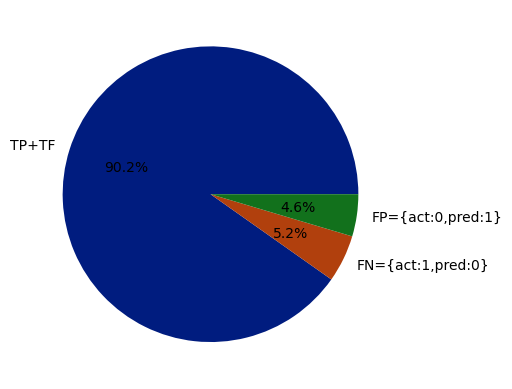

In [401]:
keys = ['TP+TF', 'FN={act:1,pred:0}','FP={act:0,pred:1}']
# define Seaborn color palette to use
palette_color = sns.color_palette('dark')
plt.pie(diff.value_counts(), labels=keys, colors=palette_color, autopct='%.1f%%');

In [404]:
X.columns

Index(['USMER', 'MEDICAL_UNIT', 'SEX', 'HOSP', 'PNEUMONIA', 'DIABETES',
       'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'OBESITY', 'RENAL_CHRONIC',
       'TOBACCO', 'CLASIFFICATION_FINAL', 'AGE_40-60', 'AGE_>60'],
      dtype='object')

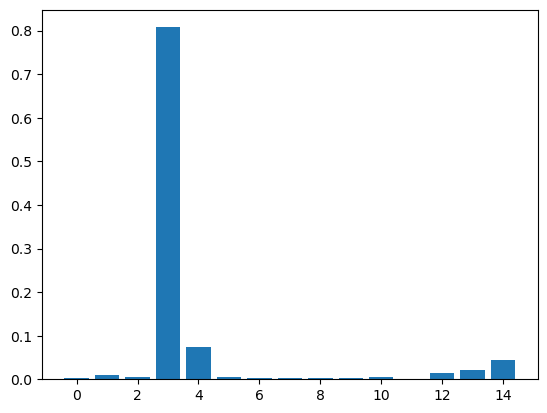

In [403]:
plt.bar(range(len(model_xgb.feature_importances_)), model_xgb.feature_importances_);

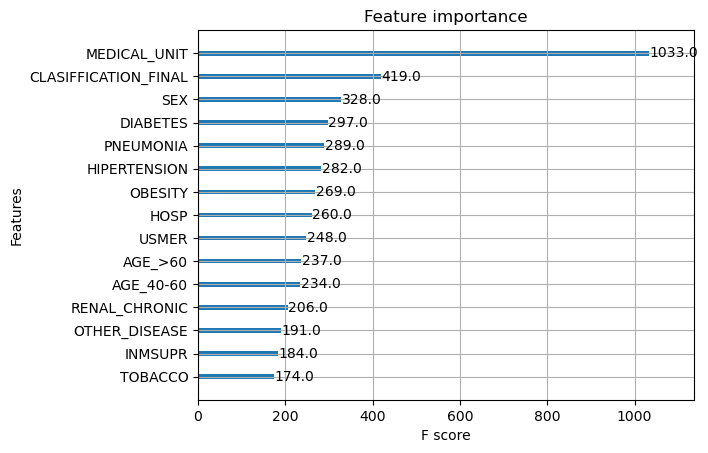

In [406]:
from xgboost import plot_importance
plot_importance(model_xgb);